# Neural Network Training

This notebooks walks through designing, training, and evaluating the performance of neural network models as part of the SLIPP project.

[Source Code: `/src/NeuralNetwork/nn.py`](../src/NeuralNetwork/nn.py)

[Documentation: `/docs/guides/NeuralNetworks/nn.md`](../docs/guides/NeuralNetworks/nn.md)

## **Introduction**

<div class="alert alert-block alert-info">

#### **Background:**

Neural Networks are a good choice for this problem because they are completely open and flexible, with no initial assumptions about how the data is structured, distributed or correlated. In theory, a NN model given enough neurons, layers, data, and training time should be able to learn all of the complex relationships that can be found in the data. There is also the benefit of being able to predict multiple outputs (temperature, geopotential height, and precipitation) from a single model.

A NN must be defined with a specific layer architecture. That is, a pre-defined arrangement of layers which specify how data is transformed from input to output. There are many different types of layers (see [Pytorch Documentation](https://pytorch.org/docs/stable/nn.html)), and the selection, size, composition, and order of these layers determine the performance of the model. For us, the biggest challenge in designing an effective NN model was therefore determining which layer architectures might perform well on this data and experimenting to see whether we could improve them.

#### **Implementation:**

Our implementation of neural networks uses PyTorch, where a custom `NeuralNetworkModule` class extends the default `torch.nn.Module` Pytorch class for integration with the standard PyTorch workflow. See this tutorial - https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html

The `NeuralNetworkModel` class contains all methods needed to initialize, train, and predict with the model, following the style of [Sci-kit Learn](https://scikit-learn.org/stable/index.html) machine learning models. We will examine each method, including its purpose, assumptions, and related design decisions throughout this notebook.
    
Architecture design was an important part of training Neural Network models, and every architecture we tried is saved in the `self.architectures` dictionary stored within the `NeuralNetworkModel` class. Below is the list of currently available architectures. See [source code](../src/NeuralNetwork/nn.py) for full details. 
    
All architectures are some combination of 2d convolution layers along the lat, lon dimensions (CNN), or flattened and fully-connected "linear" layers (FCNN). All use `ReLU` activation functions between layers.
    
*Current Defined Architectures:*
- `CNN-simple` : 2 Layer CNN
- `CNN-wide`: 2 Layer CNN with 1024 hidden channels
  - CNN hidden channels means 1024 values per latxlon point
- `CNN-deep`: 4 Layer CNN
- `CNN-deep2`: 6 Layer CNN
  - **THIS WAS OUR BEST PERFORMING MODEL
- `Linear-narrow`: 3 Layer FCNN with only 128 hidden channels
  - FCNN hidden channels means 128 values for all latxlon points
  - **THIS MODEL TRAINS VERY QUICKLY, AND HAS GOOD PERFORMANCE ON hgtprs
- `Linear-wide`: 3 Layer FCNN with 8192 hidden channels
- `Linear-deep`: 5 Layer FCNN
- `Hybrid`: 1 CNN Layer + 1 FCNN Layer
- `Hybrid-deep`: 2 CNN Layers + 2 FCNN Layers
- `Hybrid-narrow`: 2 CNN layers + 2 FCNN Layers with only 128 hidden channels

      
#### **Notebook Overview:** 

This notebook demonstrates how to initialize and train one specific NN architecture (`CNN-deep2`, assess its learning effectiveness and prediction performance on the validation data, and finally how to save the trained model to be applied on new data. We focus specifically on the details of NN model, assuming that the data has already been preprocessed as explained in [preprocessing_demo.ipynb](preprocessing_demo.ipynb). 
    
*Sections:*
    
1. Load Preprocessed Data
2. Split X & Y
3. Initialize the model
4. Train the model
5. Generate model predictions
6. Visualize model results
7. (Optionally) Save trained model


#### **Purpose:** 
    
The purpose of this notebook is to explain our decisions in designing the Neural Network models and highlight any important considerations future users should keep in mind. This workflow fits in the "exploratory" phase of the project, where the goal is to experiment and tinker with inputs, targets, architectures, and hyperparameters exclusively on the validation data. 
    
Only after a best performing model or models are determined should the final, "production" NN model be trained, after which an in-depth evaluation can take place on the test set (this work is explained in [postprocessing_evaluation_demo.ipynb](postprocessing_evaluation_demo.ipynb)).

</div>

In [8]:
import os, time
if os.getcwd().split('/')[-1] == 'notebooks' or os.getcwd().split('\\')[-1] == 'notebooks' :
    os.chdir('../') ## Move to top level directory
    
from src.NeuralNetwork.nn import *
from src.Postprocessing.utils import *

import xarray as xr
import numpy as np
import pandas as pd

import torch
from torch import nn, optim, tensor
from torchsummary import summary

In [2]:
os.getcwd() # Verify this is pointed at the MDS_Antarctica top level folder from the repo

'/media/dan/data/School/MDS_Capstone/MDS_Antarctica'

## 1. Load Preprocessed Data

See [preprocessing_demo.ipynb](preprocessing_demo.ipynb)

In [3]:
## Load monthly mean isoGSM model
train_path = 'data/preprocessed/preprocessed_train_ds.nc'
ds_train = xr.open_dataset(train_path)

valid_path = 'data/preprocessed/preprocessed_valid_ds.nc'
ds_valid = xr.open_dataset(valid_path)

## 2. Split X & Y

The first decision point is which input and output variables to include. We can see the full list of available variables by running `list(ds_train.keys())`.

To meet the goals of the project, at minimum `x_vars` must include **`d180_pr`** (delta Oxygen-18 in precipitation) and `y_vars` must include at least one (but preferably all 3) of **`hgtprs`** (geopotential height), **`pratesfc`** (precipitaiton rate), and **`tmp2m`** (temperature).

In [4]:
list(ds_train.keys())

['d18O_pr',
 'hgtprs',
 'pratesfc',
 'tmp2m',
 'deseas_d18O_pr',
 'seasonal_means_d18O_pr',
 'deseas_hgtprs',
 'seasonal_means_hgtprs',
 'deseas_pratesfc',
 'seasonal_means_pratesfc',
 'deseas_tmp2m',
 'seasonal_means_tmp2m',
 'E',
 'N',
 'month',
 'year',
 'landsfc',
 'dist_to_coast',
 'oro',
 'scaled_d18O_pr',
 'scaled_hgtprs',
 'scaled_pratesfc',
 'scaled_tmp2m',
 'scaled_deseas_d18O_pr',
 'scaled_deseas_hgtprs',
 'scaled_deseas_pratesfc',
 'scaled_deseas_tmp2m',
 'scaled_E',
 'scaled_N',
 'scaled_dist_to_coast',
 'scaled_oro']

#### Scaled and Deseasonalized Data

It's important to point out that each variable (ie. `tmp2m`) shows up multiple times in `ds_train`. This is because each time we scale (or deseasonalize) a variable we also keep the unscaled version in the xArray dataset. So part of deciding which input and output variables to use involves choosing whether to use the original, deseasonalized (ie. anomalies), scaled original, or scaled and deseasonalized versions. The table below shows how these differ for temperature:

| Variable            | Description                  | Units | Mean | Std. Dev. |
|---------------------|------------------------------|-------|------|-------|
| tmp2m               | Temperature                  | °K    | 250  | 16.0  |
| deseas_tmp2m        | Temperature Anomalies        | °K    | 0    | 2.15  |
| scaled_tmp2m        | Scaled Temperature           | n/a   | 0    | 1     |
| scaled_deseas_tmp2m | Scaled Temperature Anomalies | n/a   | 0    | 1     |

</br>

❗ Very important considerations:  
1. **NN models with multiple targets must use scaled Y variables** - This ensures the model prioritizes performance on each target variable equally.
2. **RMSE performance on `scaled_Y` vs. `scaled_deseas_Y` variables are not comparable** - *Predicting anomalies is harder* than predicting the original variable. This is because of the difference in standard deviations, which results in different scaling factors. When predicting temperature, for example, two equally-strong models would show RMSE scores approximately 8 times better predicting `scaled_tmp2m` compared to `scaled_deseas_tmp2m` (essentially, this is because the deseasonalize preprocessing step is doing work to help the anomaly models, but this work is not captured by the RMSE score on the scaled data).

#### Our Findings

Initially, we thought that a neural network should be able to learn the seasonal patterns, and so would not need deseasonalized input variables. In practice, the "head start" that deseasonalizing gave the model gave us better results, and avoided the models having to learn something we already had a method for accounting for. In theory, the right NN architecture should do a better job learning the seasonal patterns in this data than our straightforward deseasonalizing approach, but we did not see this in our experiments.

Having settled on using deseasonalized variables, we established the following set of candidate variables, which we experimented by including and excluding different combinations of. 

| Input (X) Variables     | Target (Y) Variables    |
|-------------------------|-------------------------|
| `scaled_deseas_d180_pr` | `scaled_desas_tmp2m`    |
| `scaled_E`              | `scaled_deseas_hgtprs`  |
| `scaled_N`              | `scaled_desas_pratesfc` |
| `scaled_dist_to_coast`  |                         |
| `scaled_oro`            |                         |
| `landsfc`               |                         |
| `month`               |                         |
| `year`               |                         |


Really all we're doing here is experiencing the trade off of increased model complexity and training time versus increased performance. Giving a NN more input data *should* at worst make no difference and at best improve prediction performance. However, in some cases introducing input variables that were on different scales (`month` and `year` were culprits here) hurt the models ability to learn quickly and calculate correct gradients. Since computation resources were not our limit (we always had Sockeye if we needed), it ultimately make sense to just include all the scaled variables we had and trusting the deseasonalized process to handle the temporal nature of the variables.

In [5]:
## Split X and Y & Convert to Tensors
x_vars = ['scaled_deseas_d18O_pr', 'scaled_E', 'scaled_N', 'scaled_dist_to_coast', 'scaled_oro', 'landsfc']
y_vars = ['scaled_deseas_tmp2m', 'scaled_deseas_hgtprs', 'scaled_deseas_pratesfc']

X_train, Y_train = xArray_to_tensor(ds_train, x_vars, y_vars)
X_valid, Y_valid = xArray_to_tensor(ds_valid, x_vars, y_vars)

## 3. Initialize the model

Initialize an instance of the NeuralNetworkModel class by specifying an architecture, the `x_vars` and `y_vars` lists we created, and a learning rate hyperparmeter for the optimizer.

**We must set the seed using `torch.manual_seed(seed)` before initializing the model to make our work reproducible**

During initialization, the model also defines these hardcoded attributes. Future work may want to change these, but keeping them to standard default choices worked for our needs:
- **device** = `'cpu'` | PyTorch device (hardware) to run the model on. If we wanted to run our models on a GPU this is where we specify that
- **loss_fx** = `nn.MSELoss()` | Loss function for the model to optimize. We chose MSELoss which is in line with our RMSE loss function, the same loss function the GP models use, and a standard choice for continuous numeric targets.
- **optimizer** = `optim.Adam()` | Optimizer for the model to use. Adam is a stochastic optimization algorithm for first-order gradient-boosted optimization. See [PyTorch documentation](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) 

In [6]:
# Initialize the model
torch.manual_seed(123) # Set seed for reproducibility
architecture = 'CNN-deep2'
model = NeuralNetworkModel(architecture, x_vars, y_vars, lr=1e-3)
model_summary = summary(model, X_train[0].shape)

pass

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 3, 15, 192]          --
|    └─Conv2d: 2-1                       [-1, 32, 15, 192]         16,352
|    └─ReLU: 2-2                         [-1, 32, 15, 192]         --
|    └─Conv2d: 2-3                       [-1, 32, 15, 192]         76,832
|    └─ReLU: 2-4                         [-1, 32, 15, 192]         --
|    └─Conv2d: 2-5                       [-1, 16, 15, 192]         33,296
|    └─ReLU: 2-6                         [-1, 16, 15, 192]         --
|    └─Conv2d: 2-7                       [-1, 16, 15, 192]         10,000
|    └─ReLU: 2-8                         [-1, 16, 15, 192]         --
|    └─Conv2d: 2-9                       [-1, 8, 15, 192]          4,232
|    └─ReLU: 2-10                        [-1, 8, 15, 192]          --
|    └─Conv2d: 2-11                      [-1, 3, 15, 192]          651
|    └─ReLU: 2-12                        [-1, 3, 15, 192]        

#### Model Summary

The `torchsummary.summary()` function visualizes an initialized NN model. We can inspect the sequence of layers and their shapes, calculate the number of parameters the model will end up training, and estimate the memory size requirements of the model. Mostly we used this to double check the architecture initialized correctly and didn't pay too close attention to the numbers, but it might be interesting to track how the total params and total size of each model affect training.

## 4. Train the model

The `model.fit()` function trains the model. It requires `X_train`, `Y_train`, `X_valid`, and `Y_valid` PyTorch Tensors as inputs (these are deliberately stored outside the `NeuralNetworkModel` class to allow for training on different data sets or for cross validation, though we did not implement this).

Note that calling fit() again (re-running this cell) will **resume** training from the previous point, rather than restart back at the beginning.

</br>

*Stopping Criteria:*

A NN model can be trained forever, so we had to design some stopping criteria to decide when the model has stopped learning. We call this `stall_limit`. If the model has "stalled" - or failed to improve its **validation** RMSE score - for `stall_limit` consecutive epochs, then stop training. This is paired with a significance threshold `e` which defines the smallest decrease in RMSE that counts as an improvement (this prevents tiny improvements from dragging the training on too long). Finally, there is a catch-all `max_epochs` parameter which will kill training after `max_epochs` epochs, regardless of the status of the stall limit. Note that we are using *validation* score here to try and avoid overfitting to the training data.

Setting `stall_limit` is an interesting hyperparameter to tweak. We noticed some models we trained could plateau for many consecutive epochs before finally making a breakthrough, so keeping this number too low might miss those late breakthroughs. On the other hand, models that are slow to train will take longer to complete with higher stall limits. During our experimentation, we found that **10** was a good place to start, increasing to **20** or **25** for models that showed more promise.

In [9]:
st = time.time()
results = model.fit(X_train, Y_train, X_valid, Y_valid, e = 1e-4, stall_limit = 20, max_epochs = 50)
et = time.time()
print(f'Training Time: {et-st:.2f}s')

 Epoch: 0 Val. RMSE: 1.0356
 Epoch: 1 Val. RMSE: 1.0352
 Epoch: 2 Val. RMSE: 1.0346
 Epoch: 3 Val. RMSE: 1.0325
 Epoch: 4 Val. RMSE: 1.0293
 Epoch: 5 Val. RMSE: 1.0291
 Epoch: 6 Val. RMSE: 1.0236
 Epoch: 7 Val. RMSE: 1.0244
 Epoch: 8 Val. RMSE: 1.0213
 Epoch: 9 Val. RMSE: 1.0165
 Epoch: 10 Val. RMSE: 1.0054
 Epoch: 11 Val. RMSE: 1.0040
 Epoch: 12 Val. RMSE: 0.9782
 Epoch: 13 Val. RMSE: 0.9705
 Epoch: 14 Val. RMSE: 0.9714
 Epoch: 15 Val. RMSE: 0.9735
 Epoch: 16 Val. RMSE: 0.9752
 Epoch: 17 Val. RMSE: 0.9706
 Epoch: 18 Val. RMSE: 0.9675
 Epoch: 19 Val. RMSE: 0.9659
 Epoch: 20 Val. RMSE: 0.9668
 Epoch: 21 Val. RMSE: 0.9702
 Epoch: 22 Val. RMSE: 0.9696
 Epoch: 23 Val. RMSE: 0.9671
 Epoch: 24 Val. RMSE: 0.9663
 Epoch: 25 Val. RMSE: 0.9685
 Epoch: 26 Val. RMSE: 0.9719
 Epoch: 27 Val. RMSE: 0.9688
 Epoch: 28 Val. RMSE: 0.9665
 Epoch: 29 Val. RMSE: 0.9680
 Epoch: 30 Val. RMSE: 0.9739
 Epoch: 31 Val. RMSE: 0.9698
 Epoch: 32 Val. RMSE: 0.9662
 Epoch: 33 Val. RMSE: 0.9671
 Epoch: 34 Val. RMSE: 0.

#### Learning Effectiveness

After training, we looked at the progression of training and validation RMSE scores using these simple learning effectiveness plots below. 

A well-behaved model which learns well should show the strongest learning in early epochs followed by a gradual flattening of the slope until the performance stabilizes. Train RMSE should be better (lower RMSE) than validation scores, but a widening gap between them (if training scores are improving faster than validation scores) suggests overfitting.

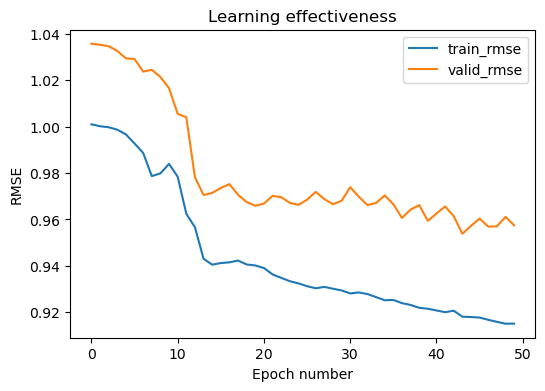

In [16]:
# Visualize training progress - model stops learning once valid_rmse line flattens out

results_df = pd.DataFrame(results)
results_df[['train_rmse', 'valid_rmse']].plot(
    figsize = (6, 4),
    title = "Learning effectiveness",
    xlabel = "Epoch number",
    ylabel = "RMSE"
)
#plt.savefig('img/NN_results/learning_effectiveness.png')
plt.show()

## 5. Generate Predictions

After the `NeuralNetworkModel` is trained, generate predictions using the trained model using the `.predict_inplace()` method. This is convenient because it places predictions back into the same `ds_valid` xArray we started with.

For each target Y variable in `y_vars` that the model was initialized with, we add a `pred_Y` and `resid_Y` variable to the xArray.  So in the standard case where we are predicting `scaled_deseas_tmp2m`, `scaled_deseas_hgtprs`, and `scaled_desesas_pratesfc` from the same model, we should see the following 6 new variables after calling `.predict_inplace()`:

| NModel Output Predictions and Residuals |
|-----------------------------------------|
| `pred_scaled_desas_tmp2m`               |
| `pred_scaled_deseas_hgtprs`             |
| `pred_scaled_desas_pratesfc`            |
| `resid_scaled_desas_tmp2m`              |
| `resid_scaled_desas_hgtprs`             |
| `resid_scaled_desas_pratesfc`           |

In [11]:
ds_predictions = model.predict_inplace(ds_valid)

## 6. Visualize Model Results

Below we're showing the postprocessing results on the validation set for the trained NN model above. Track these to compare the affects of different architectures, inputs and output variables, hyperparameter values, etc.


The complete postprocessing workflow, including how to interpret model results is left to [postprocessing_evaluation_demo.ipynb](postprocessing_evaluation_demo.ipynb). 

In [12]:
calculate_model_RMSE(ds_predictions) # Calculate model performance on each target

{'scaled_deseas_tmp2m': 0.9268406244648918,
 'scaled_deseas_hgtprs': 0.9277555670925512,
 'scaled_deseas_pratesfc': 1.015144109519738}

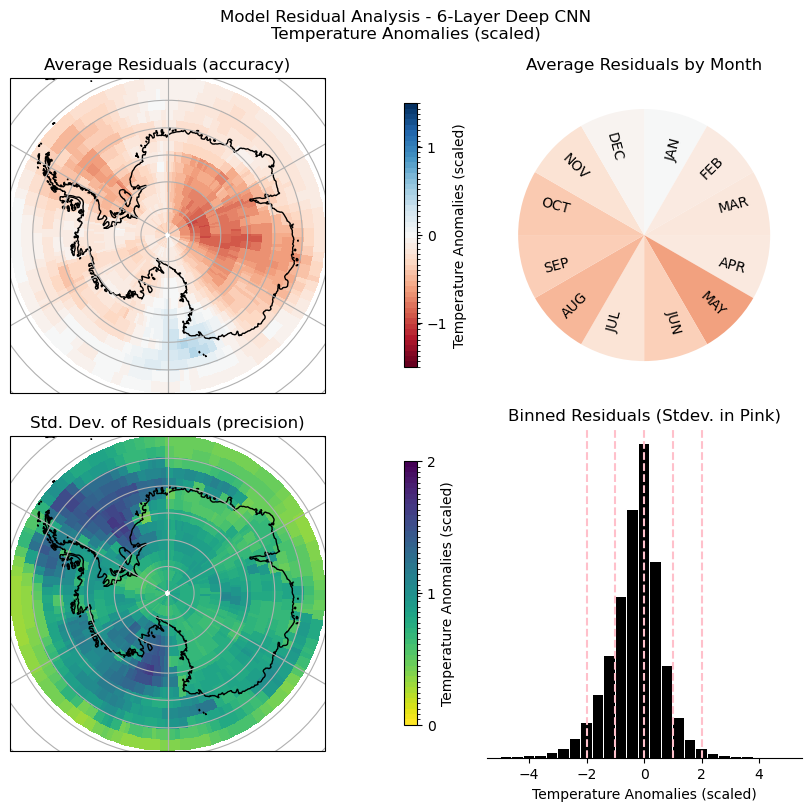

In [13]:
generate_residual_plots(ds_predictions, 
                        variable = 'resid_scaled_deseas_tmp2m', 
                        label = 'Temperature Anomalies (scaled)', 
                        model_name = '6-Layer Deep CNN',
                        out_file = None,
                        show_plot = True)

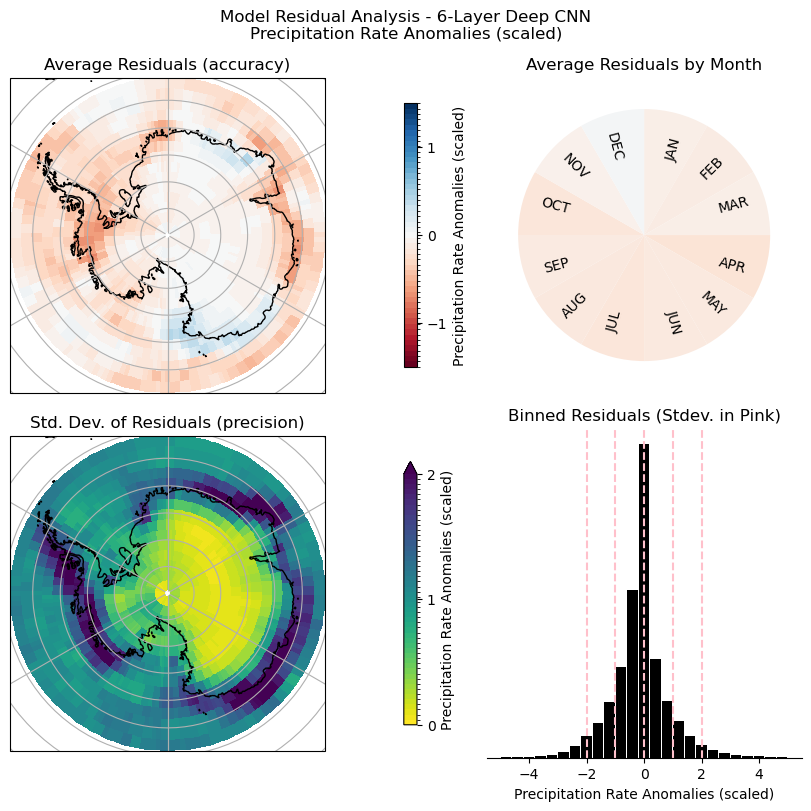

In [14]:
generate_residual_plots(ds_predictions, 
                        variable = 'resid_scaled_deseas_pratesfc', 
                        label = 'Precipitation Rate Anomalies (scaled)', 
                        model_name = '6-Layer Deep CNN',
                        out_file = None,
                        show_plot = True)

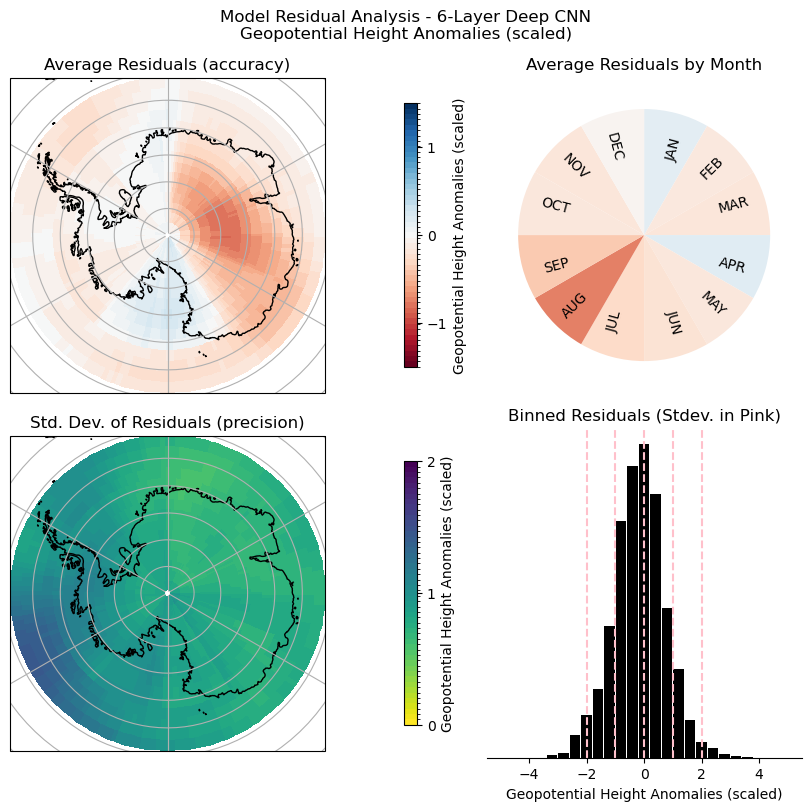

In [15]:
generate_residual_plots(ds_predictions, 
                        variable = 'resid_scaled_deseas_hgtprs', 
                        label = 'Geopotential Height Anomalies (scaled)', 
                        model_name = '6-Layer Deep CNN',
                        out_file = None,
                        show_plot = True)

## 7. (Optionally) Save model

A particularly interesting model, or one worth saving for later, can be saved as a PyTorch model `.pt` using the code below:

In [ ]:
#torch.save(model.state_dict(), 'results/models/model.pt')